## Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.


### Hypothesis Generation


What could affect the target variable (sales)?

1. Time of week : Weekends usually are more busy
2. Time of day  : Higher sales in the mornings and late evenings
3. Time of year : Higher sales at end of the year 
4. Store size and location
5. Items with more shelf space

In [1]:
# importing the librarires

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pickle
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, ElasticNet


In [2]:
# importing the training dataset

train = pd.read_csv('bigmart_train.csv')

In [3]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
train.shape

(8523, 12)

In [5]:
# 1. Missing Values in train dataset
# 2. defining a function for missing values

def missing_value(train):
    total = train.isnull().sum().sort_values(ascending=False)
    percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis = 1, keys = ['Total', 'Percent'])
    return missing_data

missing_value(train)

,Total,Percent
Outlet_Size,2410,0.282764
Item_Weight,1463,0.171653
Item_Outlet_Sales,0,0.000000
Outlet_Type,0,0.000000
Outlet_Location_Type,0,0.000000
Outlet_Establishment_Year,0,0.000000
Outlet_Identifier,0,0.000000
Item_MRP,0,0.000000
Item_Type,0,0.000000
Item_Visibility,0,0.000000


outlet size(28%) and item weight(17%) has the missing values

In [6]:
train['Item_Fat_Content'].unique()
#notice Low fat, Low Fat, LF are all the same variable

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [7]:
train['Outlet_Establishment_Year'].unique()

array([1999, 2009, 1998, 1987, 1985, 2002, 2007, 1997, 2004], dtype=int64)

In [8]:
train['Outlet_Age'] = 2018 - train['Outlet_Establishment_Year']
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,19
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,9
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,19
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,20
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,31


In [9]:
#train['Outlet_Size'].unique()

In [10]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Age
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914,20.168133
std,4.643456,0.051598,62.275067,8.371760,1706.499616,8.371760
min,4.555000,0.000000,31.290000,1985.000000,33.290000,9.000000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400,14.000000
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000,19.000000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400,31.000000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,33.000000


Item visibility has the minimum value of zero, this makes no sense because visibility can't be zero. Outlet_Establishment_Year varies from 1985 to 2009,values might not describe well so we convert it toOutlet_Age , so that we can know how old the perticular outlet is, this willput better impact.

In [11]:
train['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [12]:
train['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [13]:
train['Outlet_Size'].mode()[0]

'Medium'

In [14]:
# fill the na for outlet size with medium
#train['Outlet_Size'] = train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0])

In [15]:
# fill the na for item weight with the mean of weights
train['Item_Weight'].interpolate(inplace=True)

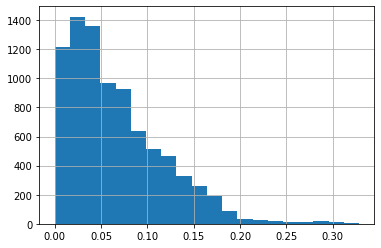

In [16]:
train['Item_Visibility'].hist(bins=20)

In [17]:
# delete the observations

Q1 = train['Item_Visibility'].quantile(0.25)
Q3 = train['Item_Visibility'].quantile(0.75)
IQR = Q3 - Q1
filt_train = train.query('(@Q1 - 1.5 * @IQR) <= Item_Visibility <= (@Q3 + 1.5 * @IQR)')

In [18]:
filt_train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,19
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,9
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,19
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,20
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,31
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850,16
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,14
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,9


In [19]:
filt_train.shape, train.shape

((8379, 13), (8523, 13))

In [20]:
train = filt_train
train.shape

(8379, 13)

In [21]:
#train['Item_Visibility'].value_counts()

In [22]:
#creating a category
train['Item_Visibility_bins'] = pd.cut(train['Item_Visibility'], [0.000, 0.065, 0.13, 0.2], labels=['Low Viz', 'Viz', 'High Viz'])

In [23]:
train['Item_Visibility_bins'].value_counts()

Low Viz     4403
Viz         2557
High Viz     893
Name: Item_Visibility_bins, dtype: int64

In [24]:
train['Item_Visibility_bins'].unique()

[Low Viz, NaN, Viz, High Viz]
Categories (3, object): [Low Viz < Viz < High Viz]

In [25]:
train['Item_Visibility_bins'] = train['Item_Visibility_bins'].replace(np.nan,'Low Viz',regex=True)


In [26]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['low fat', 'LF'], 'Low Fat')

In [27]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace('reg', 'Regular')

In [28]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Visibility_bins
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,19,Low Viz
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,9,Low Viz
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,19,Low Viz
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,20,Low Viz
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,31,Low Viz


**Encoding Categorical Variables**


In [29]:
#le = LabelEncoder()

In [30]:
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [31]:
train.replace({'Low Fat':0, 'Regular':1}, inplace=True)

In [32]:
#train['Item_Fat_Content'] = le.fit_transform(train['Item_Fat_Content'])

In [33]:
train.replace({'High Viz':2, 'Viz':1,'Low Viz':0}, inplace=True)

In [34]:
train['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [35]:
train.replace({'High':2, 'Medium':1, 'Small':0}, inplace=True)

In [36]:
train['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [37]:
train.replace({'Tier 1':2,'Tier 2':1,'Tier 3':0},inplace = True)
print(train["Outlet_Location_Type"].value_counts())

0    3283
1    2785
2    2311
Name: Outlet_Location_Type, dtype: int64


In [38]:
# create dummies for outlet type

In [39]:
item_type = pd.get_dummies(train["Item_Type"], drop_first= True)
outlet_indentifier= pd.get_dummies(train["Outlet_Identifier"], drop_first= True)
#Outlet_Type= pd.get_dummies(train["Outlet_Type"], drop_first= True)
del train["Item_Type"]
del train["Outlet_Identifier"]
#del train["Outlet_Type"]
del train["Item_Identifier"]

In [40]:
train = pd.concat([train,item_type,outlet_indentifier], axis=1)
pd.set_option('display.max_columns',None)
train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Visibility_bins,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
0,9.30,0,0.016047,249.8092,1999,1.0,2,Supermarket Type1,3735.1380,19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,5.92,1,0.019278,48.2692,2009,1.0,0,Supermarket Type2,443.4228,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,17.50,0,0.016760,141.6180,1999,1.0,2,Supermarket Type1,2097.2700,19,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,19.20,1,0.000000,182.0950,1998,NaN,0,Grocery Store,732.3800,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8.93,0,0.000000,53.8614,1987,2.0,0,Supermarket Type1,994.7052,31,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [41]:
outlet_Type= pd.get_dummies(train["Outlet_Type"], drop_first= True)
del train["Outlet_Type"]
train = pd.concat([train,outlet_Type], axis=1)


In [42]:
pd.set_option('display.max_columns',None)
train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Outlet_Age,Item_Visibility_bins,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,9.30,0,0.016047,249.8092,1999,1.0,2,3735.1380,19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,5.92,1,0.019278,48.2692,2009,1.0,0,443.4228,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,17.50,0,0.016760,141.6180,1999,1.0,2,2097.2700,19,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,19.20,1,0.000000,182.0950,1998,NaN,0,732.3800,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8.93,0,0.000000,53.8614,1987,2.0,0,994.7052,31,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [43]:
train.dtypes

Item_Weight                  float64
Item_Fat_Content               int64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Establishment_Year      int64
Outlet_Size                  float64
Outlet_Location_Type           int64
Item_Outlet_Sales            float64
Outlet_Age                     int64
Item_Visibility_bins           int64
Breads                         uint8
Breakfast                      uint8
Canned                         uint8
Dairy                          uint8
Frozen Foods                   uint8
Fruits and Vegetables          uint8
Hard Drinks                    uint8
Health and Hygiene             uint8
Household                      uint8
Meat                           uint8
Others                         uint8
Seafood                        uint8
Snack Foods                    uint8
Soft Drinks                    uint8
Starchy Foods                  uint8
OUT013                         uint8
OUT017                         uint8
O

In [44]:

train = train.drop(['Outlet_Establishment_Year','Item_Visibility'], axis=1)

In [45]:
train.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_MRP', 'Outlet_Size',
       'Outlet_Location_Type', 'Item_Outlet_Sales', 'Outlet_Age',
       'Item_Visibility_bins', 'Breads', 'Breakfast', 'Canned', 'Dairy',
       'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
       'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
       'Snack Foods', 'Soft Drinks', 'Starchy Foods', 'OUT013', 'OUT017',
       'OUT018', 'OUT019', 'OUT027', 'OUT035', 'OUT045', 'OUT046', 'OUT049',
       'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3'],
      dtype='object')

#### handling missing data by MICE

In [46]:
from statsmodels.imputation import mice 

train= mice.MICEData(train).data

**Linear Regression**

In [47]:
# build the linear regression model
X = train.drop('Item_Outlet_Sales', axis=1)
y = train.Item_Outlet_Sales

In [48]:
test = pd.read_csv('bigmart_test.csv')
#test['Outlet_Size'] = test['Outlet_Size'].fillna('Medium')

In [49]:
test['Item_Visibility_bins'] = pd.cut(test['Item_Visibility'], [0.000, 0.065, 0.13, 0.2], labels=['Low Viz', 'Viz', 'High Viz'])

In [50]:
test['Item_Weight'].interpolate(inplace=True)

In [51]:
test['Item_Visibility_bins'] = test['Item_Visibility_bins'].fillna('Low Viz')
test['Item_Visibility_bins'].head()

0    Low Viz
1    Low Viz
2        Viz
3    Low Viz
4        Viz
Name: Item_Visibility_bins, dtype: category
Categories (3, object): [Low Viz < Viz < High Viz]

In [52]:
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat', 'LF'], 'Low Fat')
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace('reg', 'Regular')

In [53]:
#test['Item_Fat_Content'] = le.fit_transform(test['Item_Fat_Content'])

In [54]:
#test['Item_Visibility_bins'] = le.fit_transform(test['Item_Visibility_bins'])

In [55]:
#test['Outlet_Size'] = le.fit_transform(test['Outlet_Size'])

In [56]:
#test['Outlet_Location_Type'] = le.fit_transform(test['Outlet_Location_Type'])

In [57]:
#test['Outlet_Age'] = 2018 - test['Outlet_Establishment_Year']

In [58]:
'''dummy = pd.get_dummies(test['Outlet_Type'])
test = pd.concat([test, dummy], axis=1)
'''

"dummy = pd.get_dummies(test['Outlet_Type'])\ntest = pd.concat([test, dummy], axis=1)\n"

In [59]:
#X_test = test.drop(['Item_Identifier', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type','Outlet_Establishment_Year'], axis=1)

In [60]:
#X.columns, X_test.columns

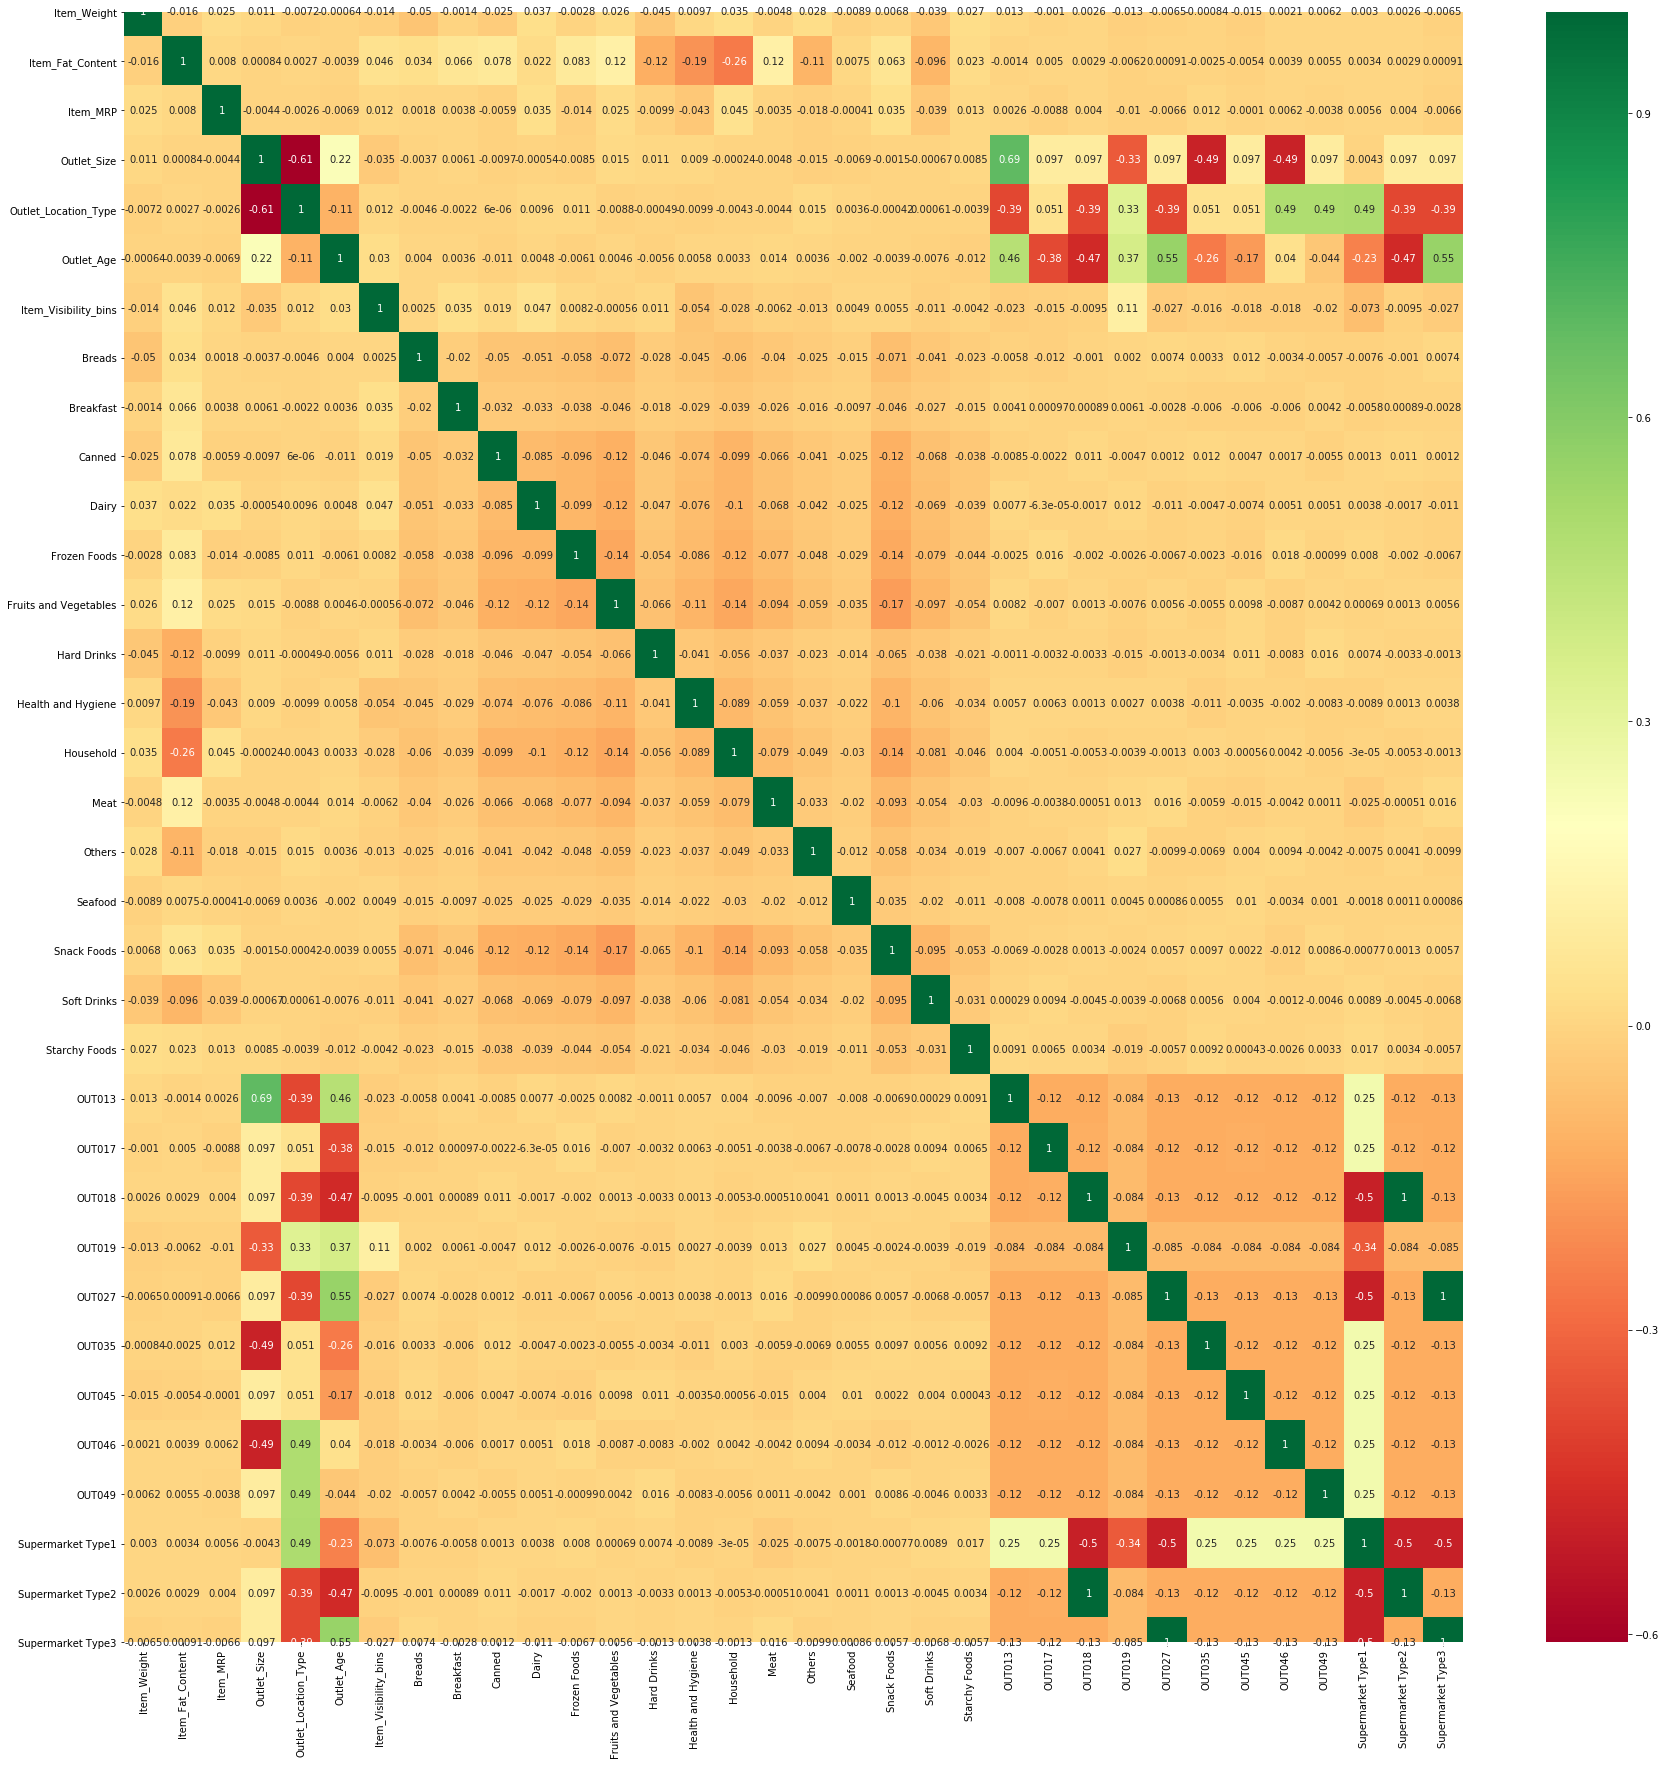

In [61]:
import seaborn as sns

plt.figure(figsize=(30,30))
sns.heatmap(X.corr(), cmap='RdYlGn', annot = True)

In [62]:
del X["OUT027"]
del X["OUT018"]

In [63]:
from sklearn import model_selection
xtrain,xtest,ytrain,ytest = model_selection.train_test_split(X,y,test_size=0.3,random_state=0)

In [64]:
sc = StandardScaler()
sc.fit_transform(xtrain)
sc.transform(xtest)

array([[-1.24280128, -0.74047988, -0.37332713, ..., -1.39862404,
         2.83250365, -0.35396016],
       [-1.56662832, -0.74047988,  0.45112156, ...,  0.71498843,
        -0.35304456, -0.35396016],
       [-1.42158079, -0.74047988,  2.00805006, ...,  0.71498843,
        -0.35304456, -0.35396016],
       ...,
       [ 1.77958443, -0.74047988,  0.15130683, ...,  0.71498843,
        -0.35304456, -0.35396016],
       [ 0.46965908, -0.74047988,  0.17378039, ..., -1.39862404,
        -0.35304456, -0.35396016],
       [ 1.08245677, -0.74047988,  0.2139446 , ...,  0.71498843,
        -0.35304456, -0.35396016]])

In [65]:
pca = PCA(n_components=0.95)
pca.fit_transform(xtrain)
pca.transform(xtest)

array([[-23.20443223],
       [ 28.02244726],
       [124.83238173],
       ...,
       [  9.42208582],
       [ 10.78822142],
       [ 13.29286002]])

In [66]:
lr = LinearRegression()

In [67]:
lr.fit(xtrain, ytrain)
print(lr.coef_)
lr.intercept_


[  -3.82565669   11.4101525    15.73838981   96.76077027  228.55882012
   28.90918532  -19.33319284   30.91204183   82.71269408  112.9774902
   36.75265715   15.41334358   42.45005043   13.23082448   52.35424944
  -26.55884393  168.84576936    6.82133011  235.22112244   60.55225782
   34.2190656   143.88593631   30.55507165  542.5067079  -669.85499697
  569.53494753  277.44766034   34.11435081   55.27539833 1509.43413656
 1963.79212747 3033.33488501]


-2545.2873178688037

In [68]:
y_pred = lr.predict(xtest)
print(sqrt(mean_squared_error(ytest, y_pred)))

1096.894220358576


#### A good RMSE for this problem is atleast 1150. 

using Ridge, Lasso, ElasticNet and XGBoost 


In [69]:
from sklearn.linear_model import Ridge
ridgeReg = Ridge(alpha=0.001, normalize=True)
ridgeReg.fit(xtrain,ytrain)
print(sqrt(mean_squared_error(ytrain, ridgeReg.predict(xtrain))))
print(sqrt(mean_squared_error(ytest, ridgeReg.predict(xtest))))
print('R2 Value/Coefficient of Determination: {}'.format(ridgeReg.score(xtest, ytest)))
print(pearsonr(ytest, ridgeReg.predict(xtest)))


1147.0667428108725
1096.8694584997609
R2 Value/Coefficient of Determination: 0.5647708394790549
(0.7515707545695283, 0.0)


1147.0622822356945
1096.8535566867
R2 Value/Coefficient of Determination: 0.5647834588158915
(0.7515829909447327, 0.0)


C:\Users\Asit\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26032366.120383263, tolerance: 1736425.703712186
  positive)


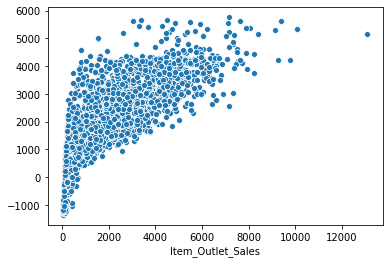

In [70]:
from scipy.stats import pearsonr
from sklearn.linear_model import Lasso
lassoreg = Lasso(alpha=0.001, normalize=True)
lassoreg.fit(xtrain, ytrain)

print(sqrt(mean_squared_error(ytrain, lassoreg.predict(xtrain))))
print(sqrt(mean_squared_error(ytest, lassoreg.predict(xtest))))
print('R2 Value/Coefficient of Determination: {}'.format(lassoreg.score(xtest, ytest)))
print(pearsonr(ytest, lassoreg.predict(xtest)))
sns.scatterplot(ytest, lassoreg.predict(xtest))

In [71]:
from sklearn.linear_model import ElasticNet
Elas = ElasticNet(alpha=0.001, normalize=True)
Elas.fit(xtrain, ytrain)

print(sqrt(mean_squared_error(ytrain, Elas.predict(xtrain))))
print(sqrt(mean_squared_error(ytest, Elas.predict(xtest))))
print('R2 Value/Coefficient of Determination: {}'.format(Elas.score(xtest, ytest)))
print(pearsonr(ytest, Elas.predict(xtest)))


1511.0044656536252
1453.1481738209695
R2 Value/Coefficient of Determination: 0.2361151472620392
(0.7098053308051067, 0.0)


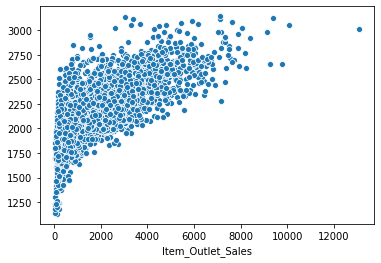

In [72]:
sns.scatterplot(ytest, Elas.predict(xtest))

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(xtrain,ytrain)
print(sqrt(mean_squared_error(ytrain, gbr.predict(xtrain))))
print(sqrt(mean_squared_error(ytest, gbr.predict(xtest))))
print('R2 Value/Coefficient of Determination: {}'.format(gbr.score(xtest, ytest)))

1052.0928528198788
1068.626752497536
R2 Value/Coefficient of Determination: 0.5868952562437993


(0.7661175265455863, 0.0)


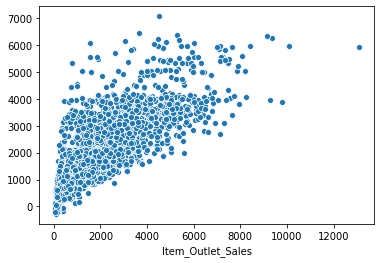

In [74]:
print(pearsonr(ytest, gbr.predict(xtest)))
sns.scatterplot(ytest, gbr.predict(xtest))

Gradient Boosting Regressor is so far the best model

In [75]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(xtrain, ytrain)

print(sqrt(mean_squared_error(ytrain, xgb.predict(xtrain))))
print(sqrt(mean_squared_error(ytest, xgb.predict(xtest))))
print('R2 Value/Coefficient of Determination: {}'.format(xgb.score(xtest, ytest)))

663.0682612305629
1173.387548691525
R2 Value/Coefficient of Determination: 0.5019292379984746


(0.7163488819152088, 0.0)


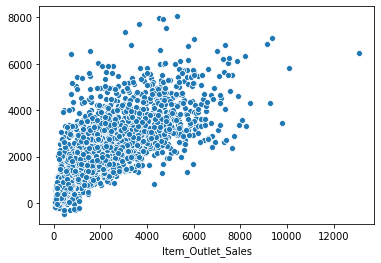

In [76]:
print(pearsonr(ytest, xgb.predict(xtest)))
sns.scatterplot(ytest, xgb.predict(xtest))

XgbRegressor is the poor fit model